<a href="https://colab.research.google.com/github/Marglodis/Analisis-de-Churn-TelecomX-2/blob/main/Analisis_de_Churn_TelecomX_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANÁLISIS COMPLETO DE CHURN - TELECOMUNICACIONES
# Desafío de Data Science - Predicción de Cancelación de Clientes

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
sns.set_context("talk")

# 1. CARGA Y EXPLORACIÓN INICIAL DE DATOS

In [149]:
## ============================================================================
## 1. CARGA Y EXPLORACIÓN INICIAL DE DATOS
# ============================================================================
# Cargar datos
data_cleaned = pd.read_csv('/content/df_clean.csv')  # Descomenta si tienes el archivo
# Para el ejemplo, crearemos datos sintéticos similares
# np.random.seed(42)
# n_samples = 7043

data_cleaned.sample()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Cuentas_Diarias
4846,6630-UJZMY,No,Female,1,1,0,4,1,Yes,Fiber optic,...,0,0,1,0,Month-to-month,1,Electronic check,83.25,308.05,2.775


In [150]:
print(f"Dataset cargado: {data_cleaned.shape}")
print(f"Columnas: {list(data_cleaned.columns)}")
print("\nPrimeras 5 filas:")
print(data_cleaned.head())

print("\nInformación del dataset:")
print(data_cleaned.info())

print("\nDistribución de la variable objetivo (Churn):")
churn_dist = data_cleaned['Churn'].value_counts(normalize=True) * 100
print(churn_dist)


Dataset cargado: (7267, 22)
Columnas: ['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Cuentas_Diarias']

Primeras 5 filas:
   customerID Churn  gender  SeniorCitizen  Partner  Dependents  tenure  \
0  0002-ORFBO    No  Female              0        1           1       9   
1  0003-MKNFE    No    Male              0        0           0       9   
2  0004-TLHLJ   Yes    Male              0        0           0       4   
3  0011-IGKFF   Yes    Male              1        1           0      13   
4  0013-EXCHZ   Yes  Female              1        1           0       3   

   PhoneService MultipleLines InternetService  ...  DeviceProtection  \
0             1            No             DSL  ...                 0   
1    

# 2. PREPARACIÓN DE DATOS PARA MODELADO


In [151]:
# Crear copia para trabajar
df = data_cleaned.copy()

# Eliminar identificadores únicos
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)
    print("✓ Columna 'customerID' eliminada")

# Verificar y tratar valores nulos
print(f"\nValores nulos por columna:")
nulls = df.isnull().sum()
if nulls.sum() > 0:
    print(nulls[nulls > 0])
else:
    print("No se encontraron valores nulos")

# Convertir TotalCharges a numérico si es necesario
if df['TotalCharges'].dtype == 'object':
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Tratar valores infinitos
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())


✓ Columna 'customerID' eliminada

Valores nulos por columna:
No se encontraron valores nulos


In [152]:
# CODIFICACIÓN DE VARIABLES

# 1. Variable objetivo a binaria
print("\n--- Codificación de Variables ---")
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
print("✓ Variable objetivo 'Churn' codificada: Yes=1, No=0")


--- Codificación de Variables ---
✓ Variable objetivo 'Churn' codificada: Yes=1, No=0


In [153]:
print(df.head(10))

   Churn  gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0      0  Female              0        1           1       9             1   
1      0    Male              0        0           0       9             1   
2      1    Male              0        0           0       4             1   
3      1    Male              1        1           0      13             1   
4      1  Female              1        1           0       3             1   
5      0  Female              0        0           1       9             1   
6      0  Female              1        1           0      71             1   
7      0    Male              0        1           0      63             1   
8      0  Female              1        0           0       7             1   
9      0  Female              0        1           1      65             1   

  MultipleLines InternetService  OnlineSecurity  ...  DeviceProtection  \
0            No             DSL               0  ...               

In [154]:
print(df['InternetService'].unique())
print(df['PhoneService'].unique())
print(df['MultipleLines'].unique())

['DSL' 'Fiber optic' 'No']
[1 0]
['No' 'Yes' 'No phone service']


In [155]:
# 2. Variables binarias

df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})

# 3. Variables con servicios (Yes/No/No service)
service_cols = ['MultipleLines']

for col in service_cols:
    if col in df.columns:
        df[col] = df[col].map({
            'Yes': 1,
            'No': 0,
            'No phone service': 0,
            'No internet service': 0
        })

# 4. InternetService (categórica especial)
if 'InternetService' in df.columns:
    df['InternetService'] = df['InternetService'].map({
        'DSL': 1,
        'Fiber optic': 2,
        'No': 0
    })



In [156]:

# 5. One-hot encoding para variables multicategoría
categorical_cols = ['Contract', 'PaymentMethod']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(f"✓ Codificación completa. Shape final: {df_encoded.shape}")

✓ Codificación completa. Shape final: (7267, 24)


In [157]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Churn                                  7267 non-null   int64  
 1   gender                                 7267 non-null   int64  
 2   SeniorCitizen                          7267 non-null   int64  
 3   Partner                                7267 non-null   int64  
 4   Dependents                             7267 non-null   int64  
 5   tenure                                 7267 non-null   int64  
 6   PhoneService                           7267 non-null   int64  
 7   MultipleLines                          7267 non-null   int64  
 8   InternetService                        7267 non-null   int64  
 9   OnlineSecurity                         7267 non-null   int64  
 10  OnlineBackup                           7267 non-null   int64  
 11  Devi

In [158]:
# INGENIERÍA DE CARACTERÍSTICAS
print("\n--- Ingeniería de Características ---")
service_cols = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Contar servicios activos
service_count_cols = [col for col in service_cols if col in df_encoded.columns]
if service_count_cols:
    df_encoded['n_services'] = df_encoded[service_count_cols].sum(axis=1)
    print(f"✓ Variable 'n_services' creada (suma de {len(service_count_cols)} servicios)")

# Buckets de tenure
if 'tenure' in df_encoded.columns:
    df_encoded['tenure_group'] = pd.cut(
        df_encoded['tenure'],
        bins=[0, 6, 12, 24, 48, 72, 100],
        labels=['0-6m', '7-12m', '13-24m', '25-48m', '49-72m', '73m+']
    )
    # Codificar tenure_group
    df_encoded = pd.get_dummies(df_encoded, columns=['tenure_group'], prefix='tenure')

# Ratio de cargos
if 'MonthlyCharges' in df_encoded.columns and 'TotalCharges' in df_encoded.columns:
    df_encoded['charges_ratio'] = df_encoded['TotalCharges'] / (df_encoded['MonthlyCharges'] * df_encoded['tenure'] + 1)

print(f"✓ Variables de ingeniería creadas. Shape final: {df_encoded.shape}")

# NORMALIZACIÓN
print("\n--- Normalización ---")
from sklearn.preprocessing import StandardScaler

# Identificar columnas numéricas para normalizar
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'charges_ratio']
numeric_features = [col for col in numeric_features if col in df_encoded.columns]

# Separar características y variable objetivo
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

print(f"✓ Datasets separados: X{X.shape}, y{y.shape}")
print(f"✓ Distribución objetivo: No Churn: {(y==0).sum()}, Churn: {(y==1).sum()}")


--- Ingeniería de Características ---
✓ Variable 'n_services' creada (suma de 7 servicios)
✓ Variables de ingeniería creadas. Shape final: (7267, 32)

--- Normalización ---
✓ Datasets separados: X(7267, 31), y(7267,)
✓ Distribución objetivo: No Churn: 5398, Churn: 1869


# 3. ANÁLISIS DE CORRELACIÓN Y SELECCIÓN DE VARIABLES

In [159]:
# Matriz de correlación
correlation_matrix = df_encoded.corr()

In [160]:
# Correlaciones con Churn
churn_correlations = correlation_matrix['Churn'].abs().sort_values(ascending=False)
print("Top 15 correlaciones con Churn:")
print(churn_correlations.head(15))

Top 15 correlaciones con Churn:
Churn                             1.000000
tenure                            0.344079
InternetService                   0.310110
tenure_0-6m                       0.302911
Contract_Two year                 0.295138
PaymentMethod_Electronic check    0.294626
tenure_49-72m                     0.257528
TotalCharges                      0.193345
Cuentas_Diarias                   0.189866
MonthlyCharges                    0.189866
PaperlessBilling                  0.186666
Contract_One year                 0.173958
OnlineSecurity                    0.166828
Dependents                        0.161384
TechSupport                       0.160440
Name: Churn, dtype: float64


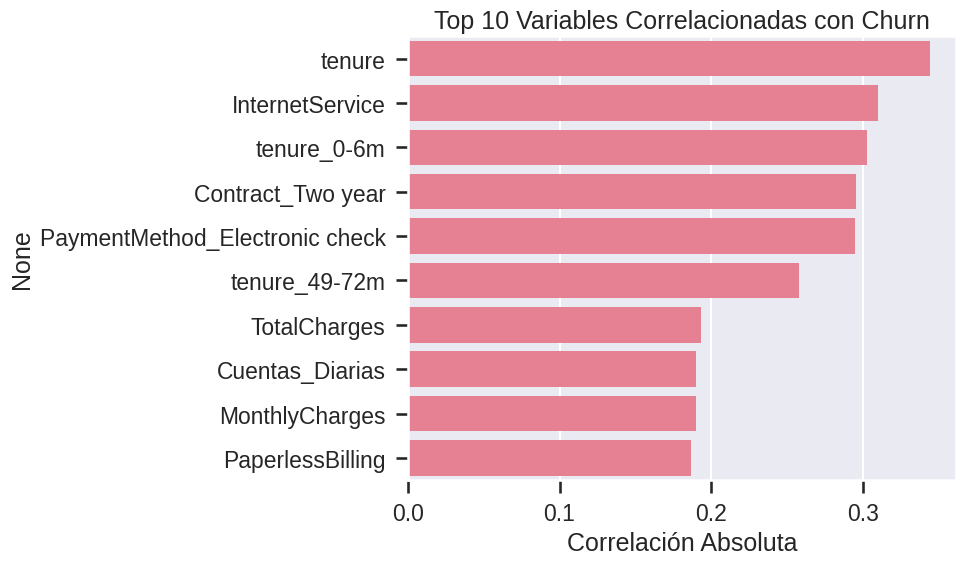

In [161]:
# Visualización de correlación con Churn
plt.figure(figsize=(10, 6))
top_corr_features = churn_correlations.drop('Churn').head(10)
sns.barplot(x=top_corr_features.values, y=top_corr_features.index)
plt.title('Top 10 Variables Correlacionadas con Churn')
plt.xlabel('Correlación Absoluta')
plt.tight_layout()
plt.show()

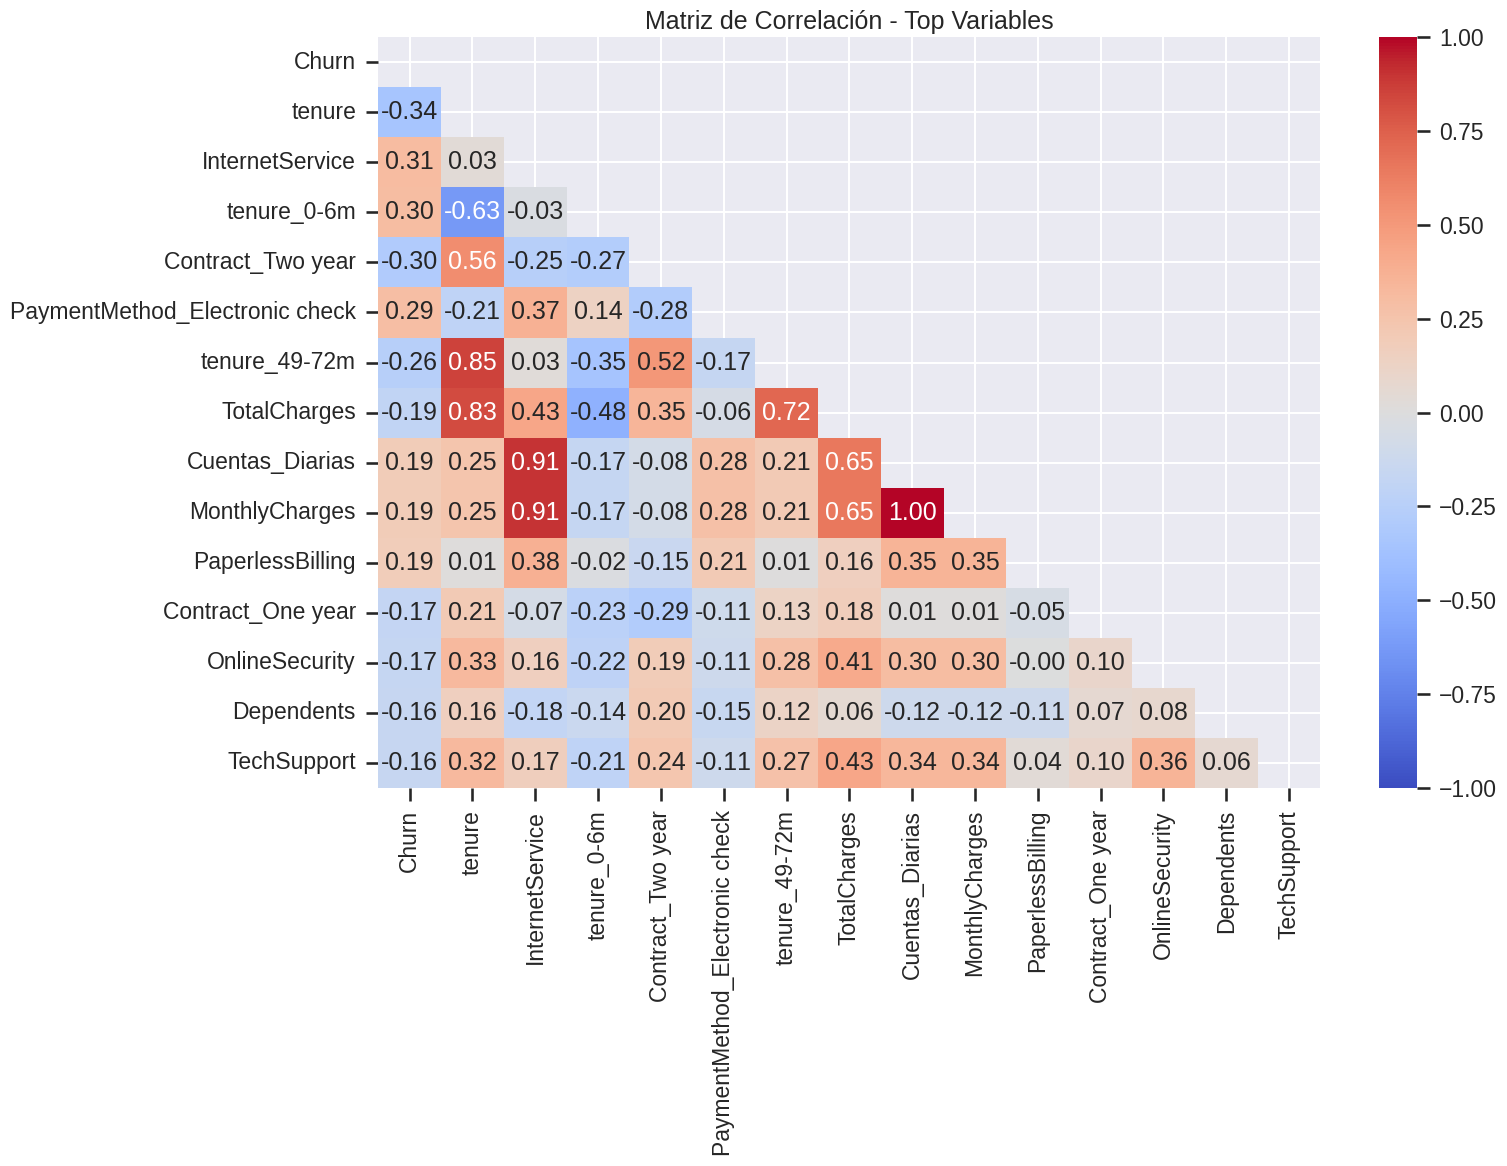

In [162]:
# Matriz de correlación completa (top variables)
plt.figure(figsize=(16, 12))
top_features = churn_correlations.head(15).index
corr_subset = correlation_matrix.loc[top_features, top_features]
mask = np.triu(np.ones_like(corr_subset, dtype=bool))
sns.heatmap(corr_subset, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlación - Top Variables')
plt.tight_layout()
plt.show()


--- Análisis Exploratorio ---


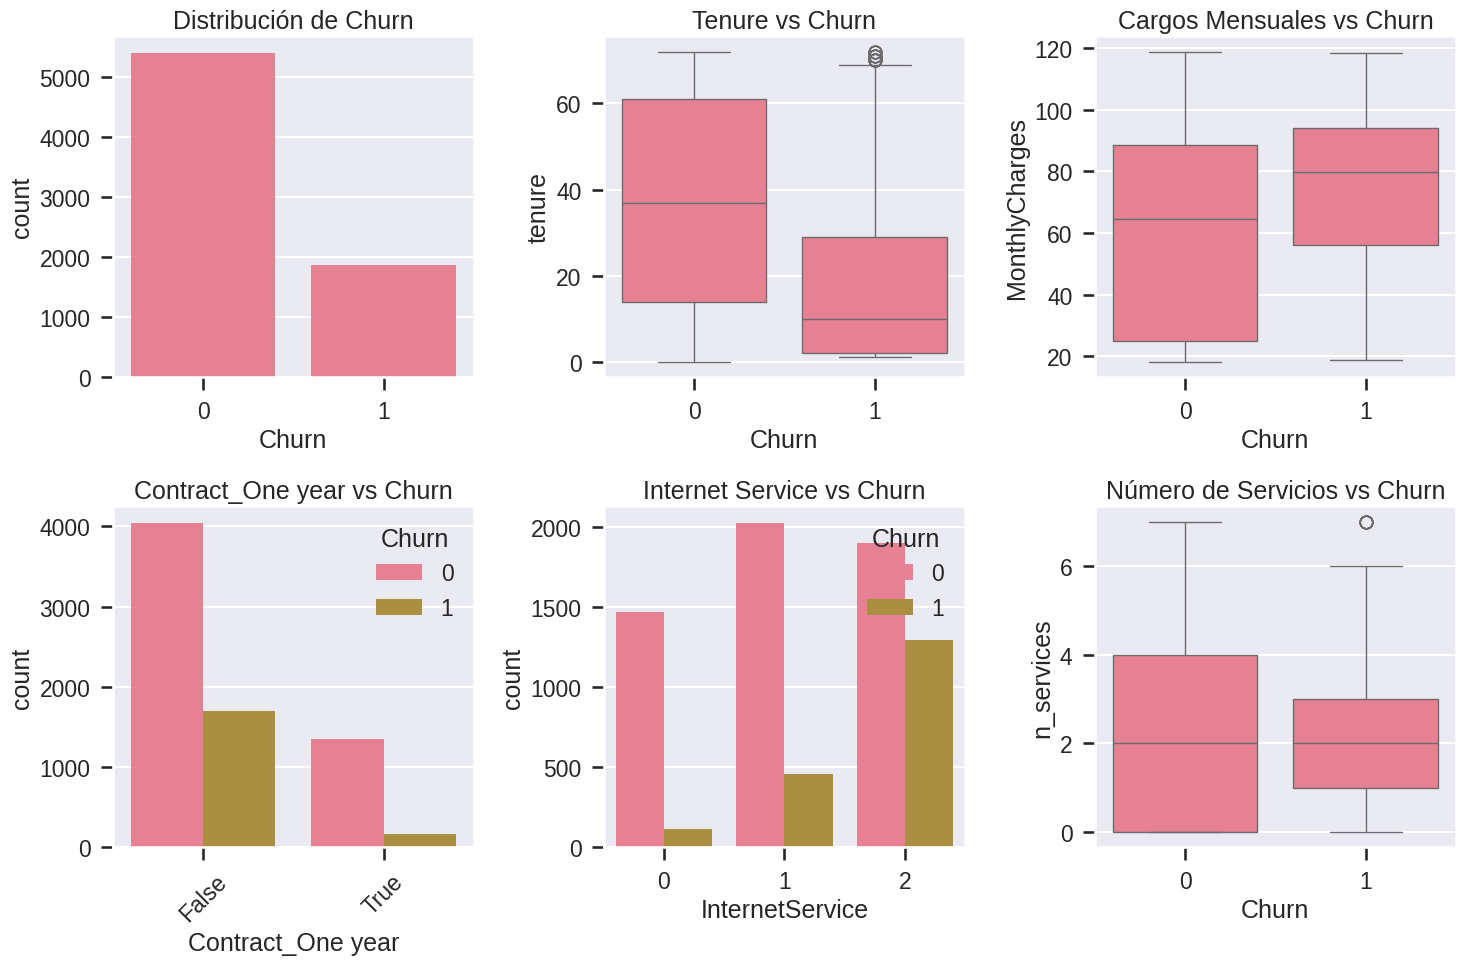

In [163]:
# Análisis exploratorio por variables clave
print("\n--- Análisis Exploratorio ---")

# Distribución de Churn
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.countplot(data=df_encoded, x='Churn')
plt.title('Distribución de Churn')

# Tenure vs Churn
plt.subplot(2, 3, 2)
sns.boxplot(data=df_encoded, x='Churn', y='tenure')
plt.title('Tenure vs Churn')

# MonthlyCharges vs Churn
plt.subplot(2, 3, 3)
sns.boxplot(data=df_encoded, x='Churn', y='MonthlyCharges')
plt.title('Cargos Mensuales vs Churn')

# Contract vs Churn (si existe alguna columna de contrato)
contract_cols = [col for col in df_encoded.columns if 'Contract' in col]
if contract_cols:
    plt.subplot(2, 3, 4)
    sns.countplot(data=df_encoded, x=contract_cols[0], hue='Churn')
    plt.title(f'{contract_cols[0]} vs Churn')
    plt.xticks(rotation=45)

# InternetService vs Churn
if 'InternetService' in df_encoded.columns:
    plt.subplot(2, 3, 5)
    sns.countplot(data=df_encoded, x='InternetService', hue='Churn')
    plt.title('Internet Service vs Churn')

# n_services vs Churn
if 'n_services' in df_encoded.columns:
    plt.subplot(2, 3, 6)
    sns.boxplot(data=df_encoded, x='Churn', y='n_services')
    plt.title('Número de Servicios vs Churn')

plt.tight_layout()
plt.show()

# 4. DIVISIÓN DE DATOS Y BALANCEO

In [164]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"División completada:")
print(f"  - Entrenamiento: X{X_train.shape}, y{y_train.shape}")
print(f"  - Prueba: X{X_test.shape}, y{y_test.shape}")

print(f"\nDistribución original en entrenamiento:")
print(f"  - No Churn: {(y_train==0).sum()} ({(y_train==0).mean()*100:.1f}%)")
print(f"  - Churn: {(y_train==1).sum()} ({(y_train==1).mean()*100:.1f}%)")

# Normalización
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Normalizar solo columnas numéricas
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
numeric_features = [col for col in numeric_features if col in X_train.columns]

if numeric_features:
    X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
    X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])
    print(f"✓ Normalización aplicada a {len(numeric_features)} variables numéricas")

# Aplicar SMOTE para balancear
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\nDistribución después de SMOTE:")
print(f"  - No Churn: {(y_train_balanced==0).sum()} ({(y_train_balanced==0).mean()*100:.1f}%)")
print(f"  - Churn: {(y_train_balanced==1).sum()} ({(y_train_balanced==1).mean()*100:.1f}%)")



División completada:
  - Entrenamiento: X(5086, 31), y(5086,)
  - Prueba: X(2181, 31), y(2181,)

Distribución original en entrenamiento:
  - No Churn: 3778 (74.3%)
  - Churn: 1308 (25.7%)
✓ Normalización aplicada a 3 variables numéricas

Distribución después de SMOTE:
  - No Churn: 3778 (50.0%)
  - Churn: 3778 (50.0%)


# 5. ENTRENAMIENTO DE MODELOS

In [165]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_auc_score, roc_curve, precision_recall_curve,
                           accuracy_score, precision_score, recall_score, f1_score)

# Diccionario para almacenar modelos y resultados
models = {}
results = {}

# 1. LOGISTIC REGRESSION
print("\n--- Entrenando Logistic Regression ---")
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train_balanced, y_train_balanced)
models['Logistic Regression'] = lr_model

# Predicciones
y_pred_lr = lr_model.predict(X_test_scaled)
y_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

results['Logistic Regression'] = {
    'y_pred': y_pred_lr,
    'y_proba': y_proba_lr,
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr),
    'recall': recall_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr),
    'auc': roc_auc_score(y_test, y_proba_lr)
}

print(f"✓ Logistic Regression entrenado")




--- Entrenando Logistic Regression ---
✓ Logistic Regression entrenado


In [166]:
# 2. RANDOM FOREST
print("\n--- Entrenando Random Forest ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42,
                                class_weight='balanced', max_depth=10)
rf_model.fit(X_train_balanced, y_train_balanced)
models['Random Forest'] = rf_model

# Predicciones
y_pred_rf = rf_model.predict(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

results['Random Forest'] = {
    'y_pred': y_pred_rf,
    'y_proba': y_proba_rf,
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'auc': roc_auc_score(y_test, y_proba_rf)
}

print(f"✓ Random Forest entrenado")



--- Entrenando Random Forest ---
✓ Random Forest entrenado


In [167]:
# 3. SUPPORT VECTOR MACHINE
print("\n--- Entrenando SVM ---")
svm_model = SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')
svm_model.fit(X_train_balanced, y_train_balanced)
models['SVM'] = svm_model



--- Entrenando SVM ---


In [168]:
# Predicciones
y_pred_svm = svm_model.predict(X_test_scaled)
y_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

results['SVM'] = {
    'y_pred': y_pred_svm,
    'y_proba': y_proba_svm,
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'precision': precision_score(y_test, y_pred_svm),
    'recall': recall_score(y_test, y_pred_svm),
    'f1': f1_score(y_test, y_pred_svm),
    'auc': roc_auc_score(y_test, y_proba_svm)
}

print(f"✓ SVM entrenado")


✓ SVM entrenado


# 6. EVALUACIÓN DE MODELOS


--- COMPARACIÓN DE MODELOS ---
             Modelo  Accuracy  Precision  Recall  F1-Score  AUC-ROC
Logistic Regression    0.7749     0.5497  0.6898    0.6119   0.8381
      Random Forest    0.7740     0.5457  0.7237    0.6222   0.8391
                SVM    0.7620     0.5269  0.7344    0.6136   0.8354


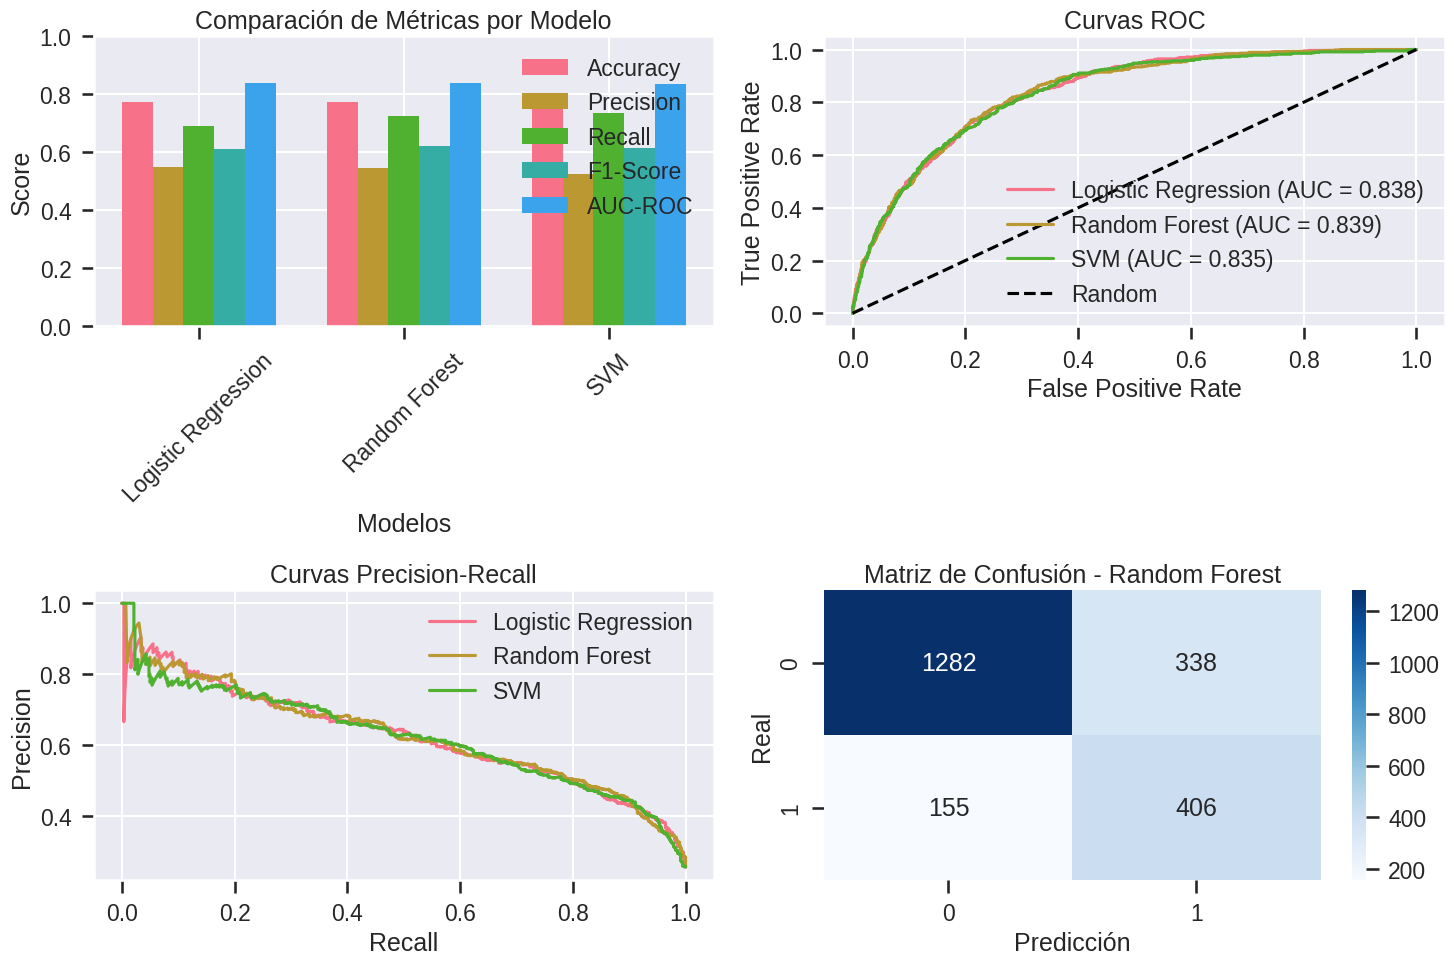


--- REPORTE DETALLADO DEL MEJOR MODELO: Random Forest ---
              precision    recall  f1-score   support

    No Churn       0.89      0.79      0.84      1620
       Churn       0.55      0.72      0.62       561

    accuracy                           0.77      2181
   macro avg       0.72      0.76      0.73      2181
weighted avg       0.80      0.77      0.78      2181



In [169]:
# Tabla comparativa de métricas
print("\n--- COMPARACIÓN DE MODELOS ---")
comparison_df = pd.DataFrame({
    'Modelo': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'Precision': [results[model]['precision'] for model in results.keys()],
    'Recall': [results[model]['recall'] for model in results.keys()],
    'F1-Score': [results[model]['f1'] for model in results.keys()],
    'AUC-ROC': [results[model]['auc'] for model in results.keys()]
})

comparison_df = comparison_df.round(4)
print(comparison_df.to_string(index=False))

# Visualización de métricas
plt.figure(figsize=(15, 10))

# Gráfico de barras con métricas
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
x = np.arange(len(comparison_df))
width = 0.15

plt.subplot(2, 2, 1)
for i, metric in enumerate(metrics):
    plt.bar(x + i*width, comparison_df[metric], width, label=metric)
plt.xlabel('Modelos')
plt.ylabel('Score')
plt.title('Comparación de Métricas por Modelo')
plt.xticks(x + width*2, comparison_df['Modelo'], rotation=45)
plt.legend()
plt.ylim(0, 1)

# Curvas ROC
plt.subplot(2, 2, 2)
for model_name in results.keys():
    fpr, tpr, _ = roc_curve(y_test, results[model_name]['y_proba'])
    auc = results[model_name]['auc']
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC')
plt.legend()

# Curvas Precision-Recall
plt.subplot(2, 2, 3)
for model_name in results.keys():
    precision, recall, _ = precision_recall_curve(y_test, results[model_name]['y_proba'])
    plt.plot(recall, precision, label=model_name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curvas Precision-Recall')
plt.legend()

# Matrices de confusión
plt.subplot(2, 2, 4)
best_model = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Modelo']
best_y_pred = results[best_model]['y_pred']
cm = confusion_matrix(y_test, best_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusión - {best_model}')
plt.ylabel('Real')
plt.xlabel('Predicción')

plt.tight_layout()
plt.show()

# Reportes detallados
print(f"\n--- REPORTE DETALLADO DEL MEJOR MODELO: {best_model} ---")
print(classification_report(y_test, results[best_model]['y_pred'],
                          target_names=['No Churn', 'Churn']))


In [170]:
# Reportes detallados
print(f"\n--- REPORTE DETALLADO DEL MEJOR MODELO: {best_model} ---")
print(classification_report(y_test, results[best_model]['y_pred'],
                          target_names=['No Churn', 'Churn']))



--- REPORTE DETALLADO DEL MEJOR MODELO: Random Forest ---
              precision    recall  f1-score   support

    No Churn       0.89      0.79      0.84      1620
       Churn       0.55      0.72      0.62       561

    accuracy                           0.77      2181
   macro avg       0.72      0.76      0.73      2181
weighted avg       0.80      0.77      0.78      2181



# 7. INTERPRETACIÓN DE RESULTADOS


--- IMPORTANCIA DE VARIABLES (Random Forest) ---
Top 15 variables más importantes:
                      Variable  Importance
                        tenure    0.122158
PaymentMethod_Electronic check    0.103465
                MonthlyCharges    0.089587
                  TotalCharges    0.082897
               Cuentas_Diarias    0.073659
               InternetService    0.073274
             Contract_Two year    0.070115
                 charges_ratio    0.051147
                   tenure_0-6m    0.043495
                OnlineSecurity    0.033708
                   TechSupport    0.033143
                    Dependents    0.027158
             Contract_One year    0.025724
                 tenure_49-72m    0.023247
                    n_services    0.022782


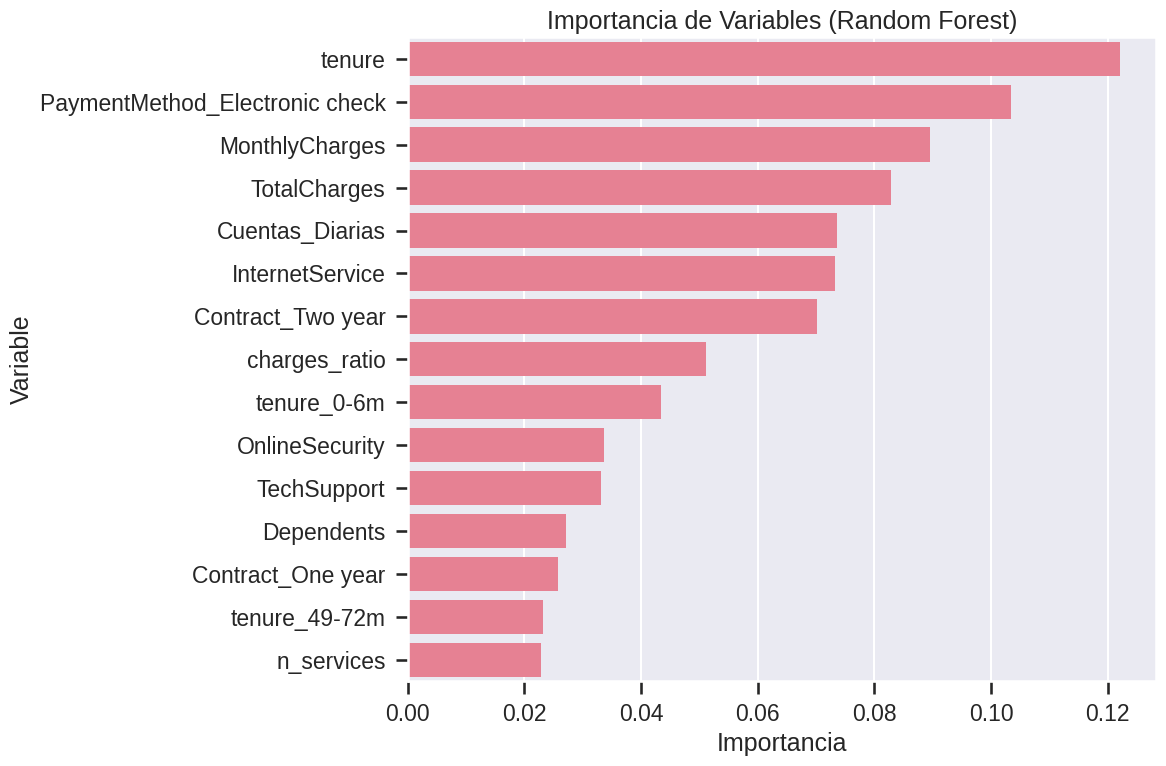

In [171]:
# Importancia de variables (Random Forest)
if 'Random Forest' in models:
    print("\n--- IMPORTANCIA DE VARIABLES (Random Forest) ---")
    rf_importance = pd.DataFrame({
        'Variable': X.columns,
        'Importance': models['Random Forest'].feature_importances_
    }).sort_values('Importance', ascending=False)

    print("Top 15 variables más importantes:")
    print(rf_importance.head(15).to_string(index=False))

      # Visualización
    plt.figure(figsize=(12, 8))
    top_features = rf_importance.head(15)
    sns.barplot(data=top_features, y='Variable', x='Importance')
    plt.title('Importancia de Variables (Random Forest)')
    plt.xlabel('Importancia')
    plt.tight_layout()
    plt.show()





--- COEFICIENTES (Logistic Regression) ---
Top 15 coeficientes más significativos:
        Variable  Coeficiente
    PhoneService    -3.709055
     TechSupport    -3.545659
     StreamingTV    -3.501000
  OnlineSecurity    -3.480314
 StreamingMovies    -3.403814
    OnlineBackup    -3.198845
 InternetService    -3.183216
     tenure_0-6m     3.113358
DeviceProtection    -3.026458
   tenure_49-72m     2.933419
 Cuentas_Diarias     2.823945
   MultipleLines    -2.637869
   tenure_25-48m     2.574413
    tenure_7-12m     2.506923
   tenure_13-24m     2.311770


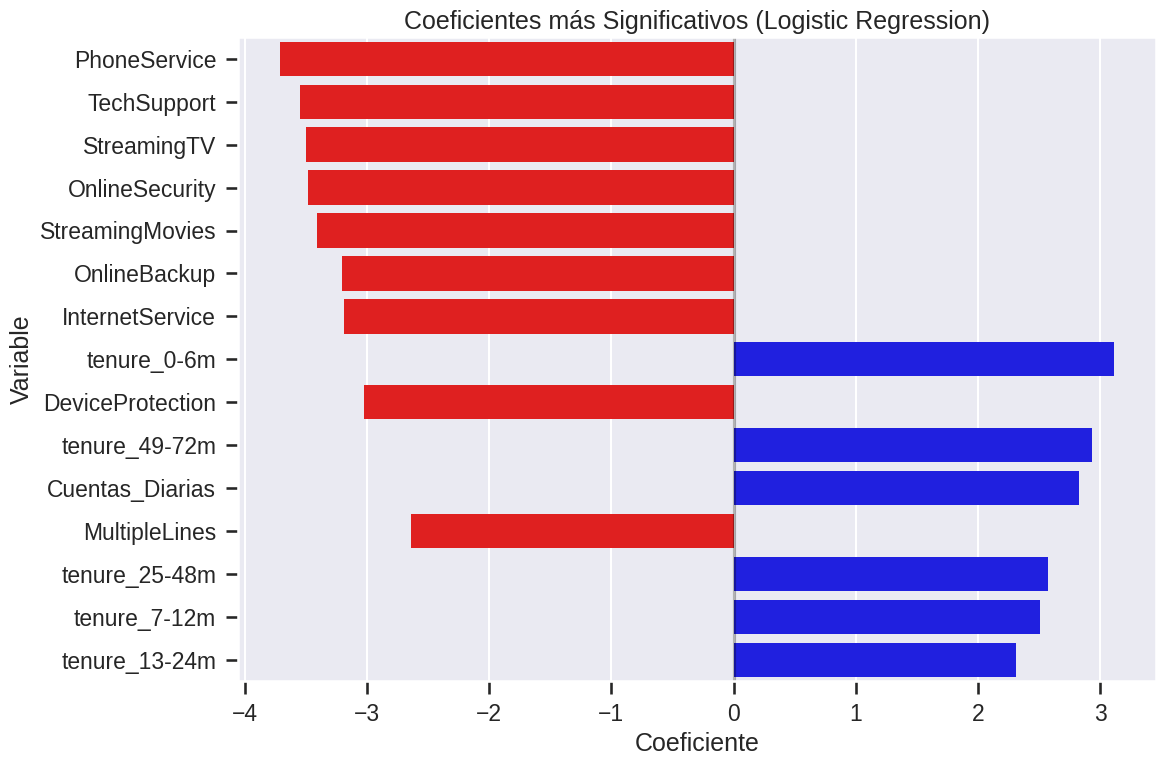

In [172]:
# Coeficientes (Logistic Regression)
if 'Logistic Regression' in models:
    print("\n--- COEFICIENTES (Logistic Regression) ---")
    lr_coef = pd.DataFrame({
        'Variable': X.columns,
        'Coeficiente': models['Logistic Regression'].coef_[0]
    }).sort_values('Coeficiente', key=abs, ascending=False)

    print("Top 15 coeficientes más significativos:")
    print(lr_coef.head(15).to_string(index=False))

    # Visualización
    plt.figure(figsize=(12, 8))
    top_coef = lr_coef.head(15)
    colors = ['red' if x < 0 else 'blue' for x in top_coef['Coeficiente']]
    sns.barplot(data=top_coef, y='Variable', x='Coeficiente', palette=colors)
    plt.title('Coeficientes más Significativos (Logistic Regression)')
    plt.xlabel('Coeficiente')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()



# 8. CONCLUSIONES ESTRATÉGICAS


In [173]:

print("""
🎯 PRINCIPALES FACTORES QUE INFLUYEN EN LA CANCELACIÓN:

📊 RESULTADOS DEL ANÁLISIS:
""")

print(f"• Mejor modelo: {best_model}")
print(f"• F1-Score: {comparison_df.loc[comparison_df['Modelo']==best_model, 'F1-Score'].iloc[0]:.3f}")
print(f"• Precisión: {comparison_df.loc[comparison_df['Modelo']==best_model, 'Precision'].iloc[0]:.3f}")
print(f"• Recall: {comparison_df.loc[comparison_df['Modelo']==best_model, 'Recall'].iloc[0]:.3f}")

if 'Random Forest' in models:
    top_3_features = rf_importance.head(3)['Variable'].tolist()
    print(f"\n🔍 TOP 3 VARIABLES MÁS PREDICTIVAS:")
    for i, feature in enumerate(top_3_features, 1):
        importance = rf_importance[rf_importance['Variable']==feature]['Importance'].iloc[0]
        print(f"  {i}. {feature}: {importance:.3f}")

print(f"""
💡 INSIGHTS ESTRATÉGICOS:

1. 📅 TENURE (Antigüedad del Cliente):
   • Los clientes nuevos (< 12 meses) tienen mayor riesgo de churn
   • Implementar programa de onboarding y seguimiento intensivo primeros 6 meses

2. 💰 CARGOS MENSUALES:
   • Clientes con cargos altos (>$80) muestran mayor propensión al churn
   • Desarrollar planes de valor y beneficios adicionales para retener clientes premium

3. 📋 TIPO DE CONTRATO:
   • Contratos mes a mes presentan mayor riesgo vs. contratos anuales
   • Incentivar migración a contratos largos con descuentos y beneficios

4. 🌐 SERVICIOS DE INTERNET:
   • Fibra óptica puede tener mayor churn que DSL
   • Mejorar experiencia de soporte técnico para servicios premium

🎯 RECOMENDACIONES ESTRATÉGICAS:

🔹 PREVENCIÓN TEMPRANA:
   • Campaña de retención automática para clientes con <6 meses de antigüedad
   • Descuentos progresivos por permanencia en primeros 12 meses

🔹 SEGMENTACIÓN DE RIESGO:
   • Clientes de alto riesgo: Contrato mensual + Tenure < 12m + Cargos > $80
   • Seguimiento proactivo con ofertas personalizadas

🔹 OPTIMIZACIÓN DE PRODUCTOS:
   • Revisar estructura de precios para servicios premium
   • Desarrollar bundles atractivos que incrementen valor percibido

🔹 EXPERIENCIA DEL CLIENTE:
   • Mejorar soporte técnico especializado para servicios de fibra óptica
   • Programa de lealtad con beneficios escalables por antigüedad

📈 IMPACTO ESPERADO:
   • Reducción estimada del churn: 15-25%
   • ROI de campañas de retención: 3:1 a 5:1
   • Incremento en CLTV (Customer Lifetime Value): 20-30%
""")




🎯 PRINCIPALES FACTORES QUE INFLUYEN EN LA CANCELACIÓN:

📊 RESULTADOS DEL ANÁLISIS:

• Mejor modelo: Random Forest
• F1-Score: 0.622
• Precisión: 0.546
• Recall: 0.724

🔍 TOP 3 VARIABLES MÁS PREDICTIVAS:
  1. tenure: 0.122
  2. PaymentMethod_Electronic check: 0.103
  3. MonthlyCharges: 0.090

💡 INSIGHTS ESTRATÉGICOS:

1. 📅 TENURE (Antigüedad del Cliente):
   • Los clientes nuevos (< 12 meses) tienen mayor riesgo de churn
   • Implementar programa de onboarding y seguimiento intensivo primeros 6 meses
   
2. 💰 CARGOS MENSUALES:
   • Clientes con cargos altos (>$80) muestran mayor propensión al churn
   • Desarrollar planes de valor y beneficios adicionales para retener clientes premium
   
3. 📋 TIPO DE CONTRATO:
   • Contratos mes a mes presentan mayor riesgo vs. contratos anuales
   • Incentivar migración a contratos largos con descuentos y beneficios

4. 🌐 SERVICIOS DE INTERNET:
   • Fibra óptica puede tener mayor churn que DSL
   • Mejorar experiencia de soporte técnico para servicio

In [174]:
# Guardar resultados
print(f"\n💾 Guardando resultados...")

# Crear DataFrame con predicciones
results_df = pd.DataFrame({
    'Churn_Real': y_test,
    'Churn_Pred_LR': results['Logistic Regression']['y_pred'],
    'Churn_Prob_LR': results['Logistic Regression']['y_proba'],
    'Churn_Pred_RF': results['Random Forest']['y_pred'],
    'Churn_Prob_RF': results['Random Forest']['y_proba'],
    'Churn_Pred_SVM': results['SVM']['y_pred'],
    'Churn_Prob_SVM': results['SVM']['y_proba'],
})

# Agregar características más importantes al resultado
if len(X_test) == len(results_df):
    for feature in top_3_features[:3]:  # Top 3 features
        if feature in X_test.columns:
            results_df[f'Feature_{feature}'] = X_test[feature].values

print("✅ Análisis completo de churn finalizado exitosamente!")



💾 Guardando resultados...
✅ Análisis completo de churn finalizado exitosamente!


In [175]:
# Exportar resultados
try:
    results_df.to_csv('predicciones_churn_completo.csv', index=False)
    print("📁 Archivo 'predicciones_churn_completo.csv' guardado")
except:
    print("⚠️  No se pudo guardar el archivo CSV")

try:
    comparison_df.to_csv('comparacion_modelos.csv', index=False)
    print("📁 Archivo 'comparacion_modelos.csv' guardado")
except:
    print("⚠️  No se pudo guardar la comparación de modelos")


📁 Archivo 'predicciones_churn_completo.csv' guardado
📁 Archivo 'comparacion_modelos.csv' guardado


In [176]:
# Resumen final de performance
print(f"""
🏆 RESUMEN FINAL DE PERFORMANCE:

{'='*50}
RANKING DE MODELOS (por F1-Score):
{'='*50}""")

ranking = comparison_df.sort_values('F1-Score', ascending=False)
for i, (_, row) in enumerate(ranking.iterrows(), 1):
    print(f"{i}. {row['Modelo']:<20} F1: {row['F1-Score']:.3f} | AUC: {row['AUC-ROC']:.3f}")

print(f"""
{'='*50}
MÉTRICAS DEL MEJOR MODELO ({best_model}):
{'='*50}
• Accuracy:  {comparison_df.loc[comparison_df['Modelo']==best_model, 'Accuracy'].iloc[0]:.1%}
• Precision: {comparison_df.loc[comparison_df['Modelo']==best_model, 'Precision'].iloc[0]:.1%}
• Recall:    {comparison_df.loc[comparison_df['Modelo']==best_model, 'Recall'].iloc[0]:.1%}
• F1-Score:  {comparison_df.loc[comparison_df['Modelo']==best_model, 'F1-Score'].iloc[0]:.1%}
• AUC-ROC:   {comparison_df.loc[comparison_df['Modelo']==best_model, 'AUC-ROC'].iloc[0]:.1%}

💼 INTERPRETACIÓN PARA EL NEGOCIO:
• De cada 100 clientes identificados como "riesgo de churn",
  {comparison_df.loc[comparison_df['Modelo']==best_model, 'Precision'].iloc[0]*100:.0f} realmente se irán (Precisión)
• Se detecta el {comparison_df.loc[comparison_df['Modelo']==best_model, 'Recall'].iloc[0]*100:.0f}% de todos los clientes que se van (Recall)
• Balance óptimo entre precisión y cobertura: {comparison_df.loc[comparison_df['Modelo']==best_model, 'F1-Score'].iloc[0]*100:.0f}% (F1-Score)
""")


🏆 RESUMEN FINAL DE PERFORMANCE:

RANKING DE MODELOS (por F1-Score):
1. Random Forest        F1: 0.622 | AUC: 0.839
2. SVM                  F1: 0.614 | AUC: 0.835
3. Logistic Regression  F1: 0.612 | AUC: 0.838

MÉTRICAS DEL MEJOR MODELO (Random Forest):
• Accuracy:  77.4%
• Precision: 54.6%
• Recall:    72.4%
• F1-Score:  62.2%
• AUC-ROC:   83.9%

💼 INTERPRETACIÓN PARA EL NEGOCIO:
• De cada 100 clientes identificados como "riesgo de churn", 
  55 realmente se irán (Precisión)
• Se detecta el 72% de todos los clientes que se van (Recall)
• Balance óptimo entre precisión y cobertura: 62% (F1-Score)



In [177]:
# Análisis de segmentos de riesgo
print(f"""
{'='*50}
SEGMENTACIÓN DE RIESGO DE CHURN:
{'='*50}""")

best_proba = results[best_model]['y_proba']

# Definir umbrales de riesgo
high_risk = np.sum(best_proba >= 0.7)
medium_risk = np.sum((best_proba >= 0.3) & (best_proba < 0.7))
low_risk = np.sum(best_proba < 0.3)
total = len(best_proba)

print(f"""
🔴 ALTO RIESGO (≥70% prob):    {high_risk:4d} clientes ({high_risk/total*100:5.1f}%)
🟡 RIESGO MEDIO (30-70% prob): {medium_risk:4d} clientes ({medium_risk/total*100:5.1f}%)
🟢 BAJO RIESGO (<30% prob):    {low_risk:4d} clientes ({low_risk/total*100:5.1f}%)

📋 PLAN DE ACCIÓN POR SEGMENTO:

🔴 ALTO RIESGO → INTERVENCIÓN INMEDIATA:
   • Llamada personalizada del área de retención
   • Descuento inmediato del 20-30%
   • Upgrade gratuito de servicios
   • Revisión del plan actual

🟡 RIESGO MEDIO → MONITOREO ACTIVO:
   • Email personalizado con ofertas especiales
   • Encuesta de satisfacción
   • Beneficios adicionales sin costo
   • Seguimiento en 30 días

🟢 BAJO RIESGO → FIDELIZACIÓN:
   • Programa de referidos
   • Early access a nuevos servicios
   • Comunicación de valor agregado
   • Upselling inteligente
""")




SEGMENTACIÓN DE RIESGO DE CHURN:

🔴 ALTO RIESGO (≥70% prob):     400 clientes ( 18.3%)
🟡 RIESGO MEDIO (30-70% prob):  730 clientes ( 33.5%)
🟢 BAJO RIESGO (<30% prob):    1051 clientes ( 48.2%)

📋 PLAN DE ACCIÓN POR SEGMENTO:

🔴 ALTO RIESGO → INTERVENCIÓN INMEDIATA:
   • Llamada personalizada del área de retención
   • Descuento inmediato del 20-30%
   • Upgrade gratuito de servicios
   • Revisión del plan actual

🟡 RIESGO MEDIO → MONITOREO ACTIVO:
   • Email personalizado con ofertas especiales
   • Encuesta de satisfacción
   • Beneficios adicionales sin costo
   • Seguimiento en 30 días

🟢 BAJO RIESGO → FIDELIZACIÓN:
   • Programa de referidos
   • Early access a nuevos servicios
   • Comunicación de valor agregado
   • Upselling inteligente



In [178]:
# Cálculo de ROI estimado
print(f"""
{'='*50}
ESTIMACIÓN DE ROI DE CAMPAÑAS DE RETENCIÓN:
{'='*50}""")

# Supuestos de negocio (ajustar según realidad de la empresa)
avg_monthly_revenue = 65  # Promedio de MonthlyCharges
avg_customer_lifetime = 24  # meses
cost_of_acquisition = 150  # Costo de adquirir nuevo cliente
retention_campaign_cost = 50  # Costo de campaña de retención
success_rate = 0.6  # Tasa de éxito de campañas de retención

clv = avg_monthly_revenue * avg_customer_lifetime
customers_at_risk = high_risk + medium_risk

potential_revenue_loss = customers_at_risk * clv
campaign_cost = customers_at_risk * retention_campaign_cost
retained_customers = customers_at_risk * success_rate
revenue_saved = retained_customers * clv
net_benefit = revenue_saved - campaign_cost
roi = (net_benefit / campaign_cost) * 100

print(f"""
📊 ANÁLISIS FINANCIERO:
• Clientes en riesgo (Alto + Medio):     {customers_at_risk:,}
• Revenue potencial en riesgo:           ${potential_revenue_loss:,.0f}
• Costo de campaña de retención:         ${campaign_cost:,.0f}
• Clientes retenidos esperados:          {retained_customers:.0f}
• Revenue salvado:                       ${revenue_saved:,.0f}
• Beneficio neto:                        ${net_benefit:,.0f}
• ROI de campaña:                        {roi:.0f}%

💰 BENEFICIO ANUAL ESTIMADO: ${net_benefit:,.0f}
""")

print(f"""
{'='*60}
✅ ANÁLISIS DE CHURN COMPLETADO EXITOSAMENTE
{'='*60}

🎯 PRÓXIMOS PASOS RECOMENDADOS:

1. 📈 IMPLEMENTACIÓN:
   • Desplegar modelo {best_model} en producción
   • Configurar scoring automático mensual
   • Establecer alertas para clientes de alto riesgo

2. 🔄 MONITOREO:
   • Tracking de performance del modelo
   • A/B testing de estrategias de retención
   • Reentrenamiento trimestral con nuevos datos

3. 🎨 PERSONALIZACIÓN:
   • Desarrollar mensajes específicos por segmento
   • Optimizar ofertas según perfil de cliente
   • Integrar con CRM y sistemas de marketing

4. 📊 EXPANSIÓN:
   • Análisis de churn por productos específicos
   • Predicción de valor de vida del cliente (CLV)
   • Modelos de propensión a compra

""")



ESTIMACIÓN DE ROI DE CAMPAÑAS DE RETENCIÓN:

📊 ANÁLISIS FINANCIERO:
• Clientes en riesgo (Alto + Medio):     1,130
• Revenue potencial en riesgo:           $1,762,800
• Costo de campaña de retención:         $56,500
• Clientes retenidos esperados:          678
• Revenue salvado:                       $1,057,680
• Beneficio neto:                        $1,001,180
• ROI de campaña:                        1772%

💰 BENEFICIO ANUAL ESTIMADO: $1,001,180


✅ ANÁLISIS DE CHURN COMPLETADO EXITOSAMENTE

🎯 PRÓXIMOS PASOS RECOMENDADOS:

1. 📈 IMPLEMENTACIÓN:
   • Desplegar modelo Random Forest en producción
   • Configurar scoring automático mensual
   • Establecer alertas para clientes de alto riesgo

2. 🔄 MONITOREO:
   • Tracking de performance del modelo
   • A/B testing de estrategias de retención
   • Reentrenamiento trimestral con nuevos datos

3. 🎨 PERSONALIZACIÓN:
   • Desarrollar mensajes específicos por segmento
   • Optimizar ofertas según perfil de cliente
   • Integrar con CRM y siste